# Set UP

In [5]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from utils import * 
from models.auto_encoder import * 
# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

# Load Data 

In [6]:
data = pd.read_csv('preprocessed_data.csv')

In [7]:
data['ID'].unique()

array(['06EB002', '08MG012', '05RE003', '05SB006', '05SD002', '05SG001',
       '05RF001', '05SD001', '05SA003', '05LH001', '05LK002', '05LL012',
       '02DD006', '05MD009', '05PD029', '05PE014', '05LM005', '02JE011',
       '05RD005', '07EA007', '05TG005', '02YF002', '05KL005', '05AB037',
       '02OH001', '08MH149', '05KK002', '02YL009', '05UD001', '05LJ009',
       '02YL007', '08NH127', '06EB007', '05RD006', '05TF001', '01AO010',
       '05CB006', '01AR013', '01AR009', '01AO003', '02YK010', '05ND012',
       '02HB021', '02JD013', '02GA030', '08LG046', '05KK005', '05PF070',
       '08NM083', '05AA032', '02JE024', '02LA015', '02OA013', '08FA007',
       '05QC004', '05UB005', '06EA012', '08KH011', '05NB032', '05PB024',
       '05PB007', '05TF004'], dtype=object)

In [8]:
example = data[data['ID'] == '05RE003']

In [9]:
example.head()

,Date,ID,PARAM,Value,Latitude,Longitude
14608,2000-01-02,05RE003,2,217.434,52.81842,-97.61956
14609,2000-01-03,05RE003,2,217.442,52.81842,-97.61956
14610,2000-01-04,05RE003,2,217.440,52.81842,-97.61956
14611,2000-01-05,05RE003,2,217.438,52.81842,-97.61956
14612,2000-01-06,05RE003,2,217.435,52.81842,-97.61956


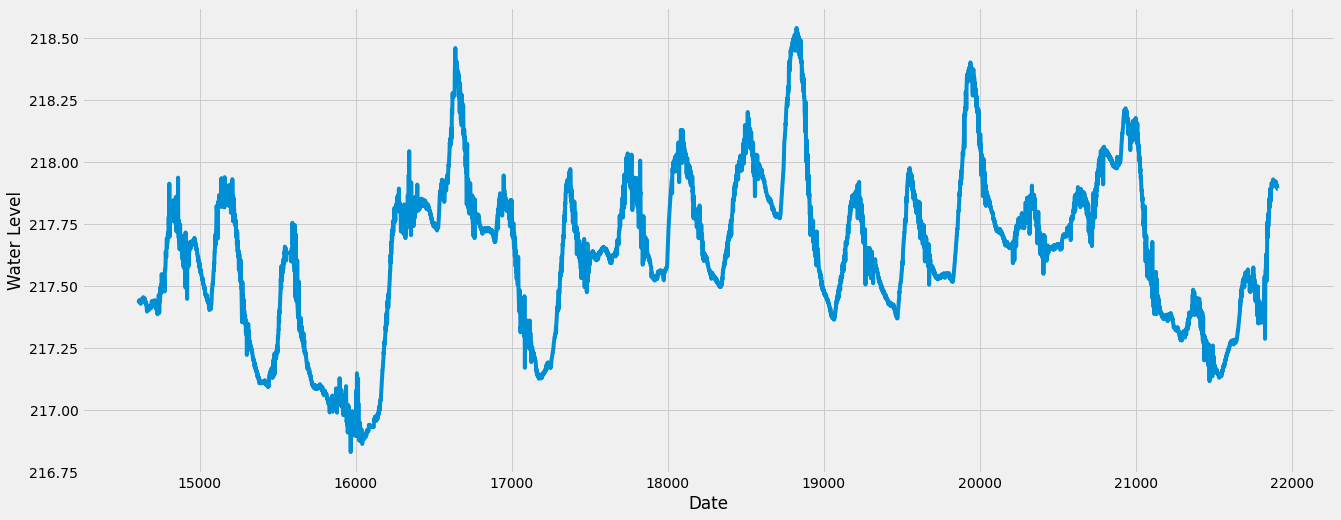

In [10]:
plt.xlabel("Date")
plt.ylabel("Water Level")
plt.plot(example["Value"])
plt.show()

### Stationarity 

in the time series forecasting, we search usually for a stationary series. The series should have a constant mean, variance, and covariance.

so let's check if the  Water Level series is stationary or not. to do this i will use ADF (Augmented Dickey-Fuller) Test :

* Null Hypothesis: The series has a unit root
* Alternate Hypothesis: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary.

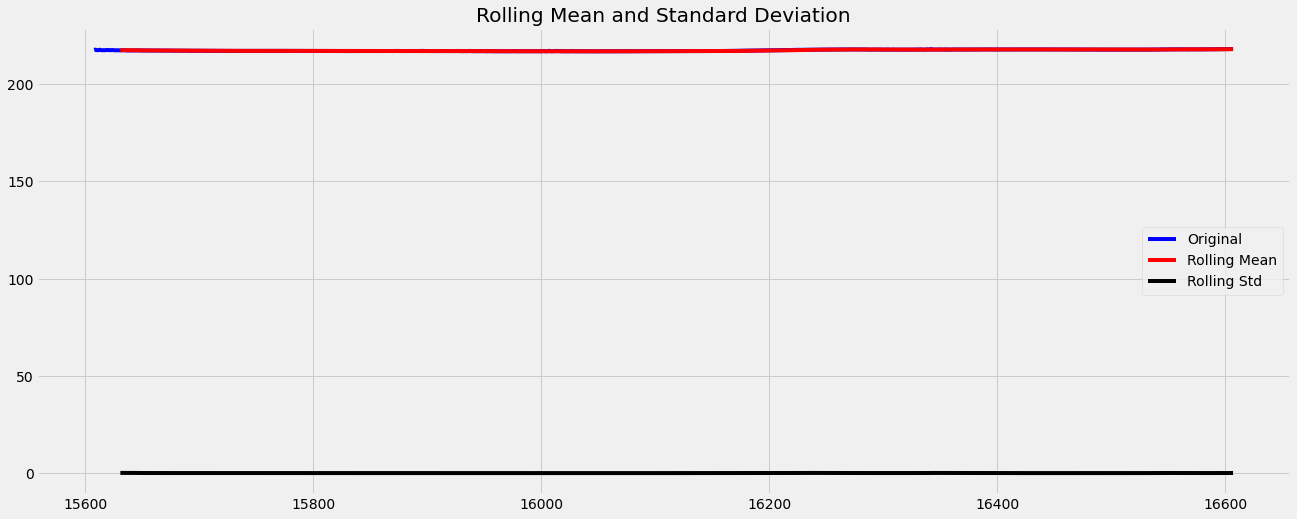

Results of dickey fuller test
Test Statistics                  0.026187
p-value                          0.960645
No. of lags used                16.000000
Number of observations used    983.000000
critical value (1%)             -3.437020
critical value (5%)             -2.864485
critical value (10%)            -2.568338
dtype: float64


In [11]:
test_stationarity(example["Value"].iloc[1000:2000])

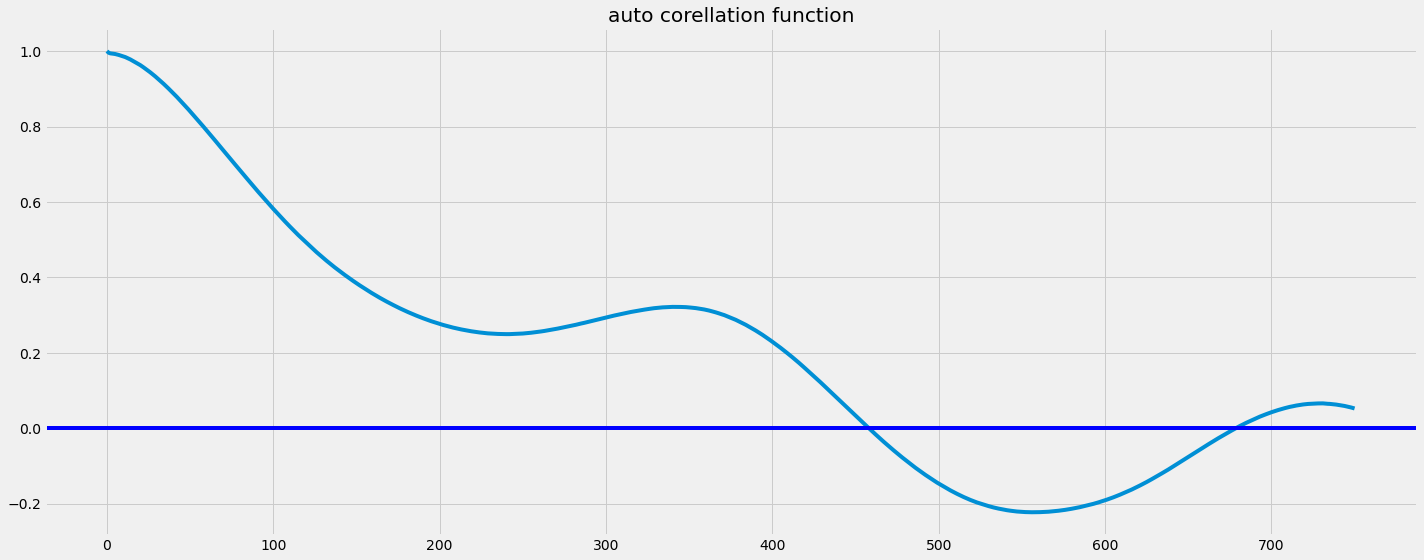

In [12]:
# we use d value here(data_log_shift)
_acf = acf(example['Value'], nlags=750)
#plot ACF
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('auto corellation function')
plt.tight_layout()

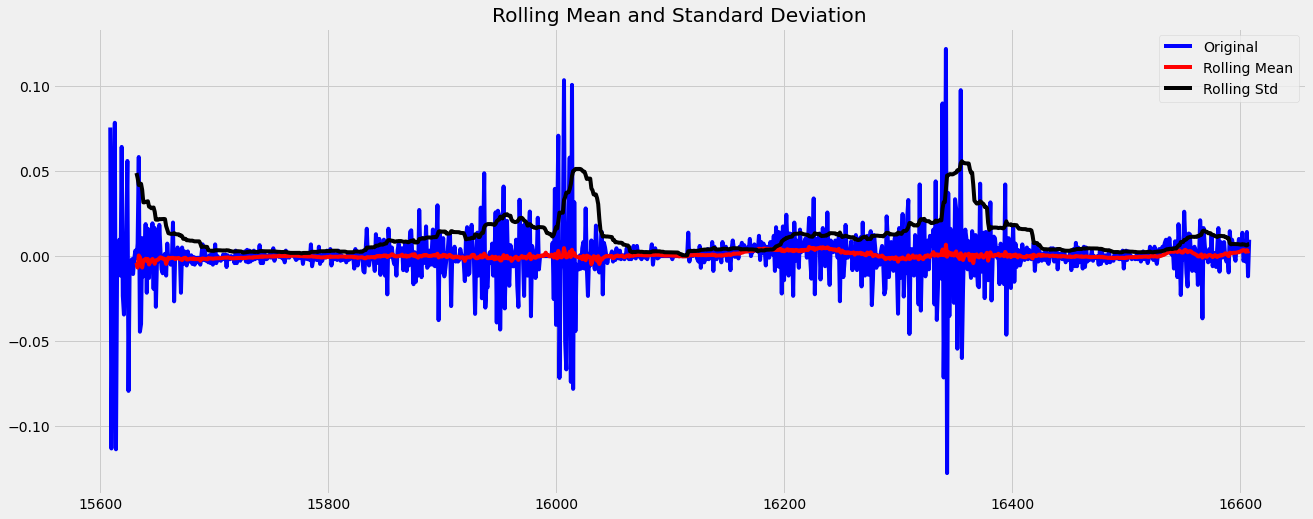

Results of dickey fuller test
Test Statistics                 -4.401530
p-value                          0.000295
No. of lags used                15.000000
Number of observations used    984.000000
critical value (1%)             -3.437013
critical value (5%)             -2.864482
critical value (10%)            -2.568336
dtype: float64


In [13]:
from numpy import inf
example['Water Level_previous'] = example["Value"].shift(1) 
example['WL_pct'] = 100*(example["Value"]  - example['Water Level_previous'] ) / example['Water Level_previous']
example.dropna(inplace = True)
example['WL_pct'] = example['WL_pct'].replace([+inf , - inf] , 0)
test_stationarity(example['WL_pct'].iloc[1000:2000])

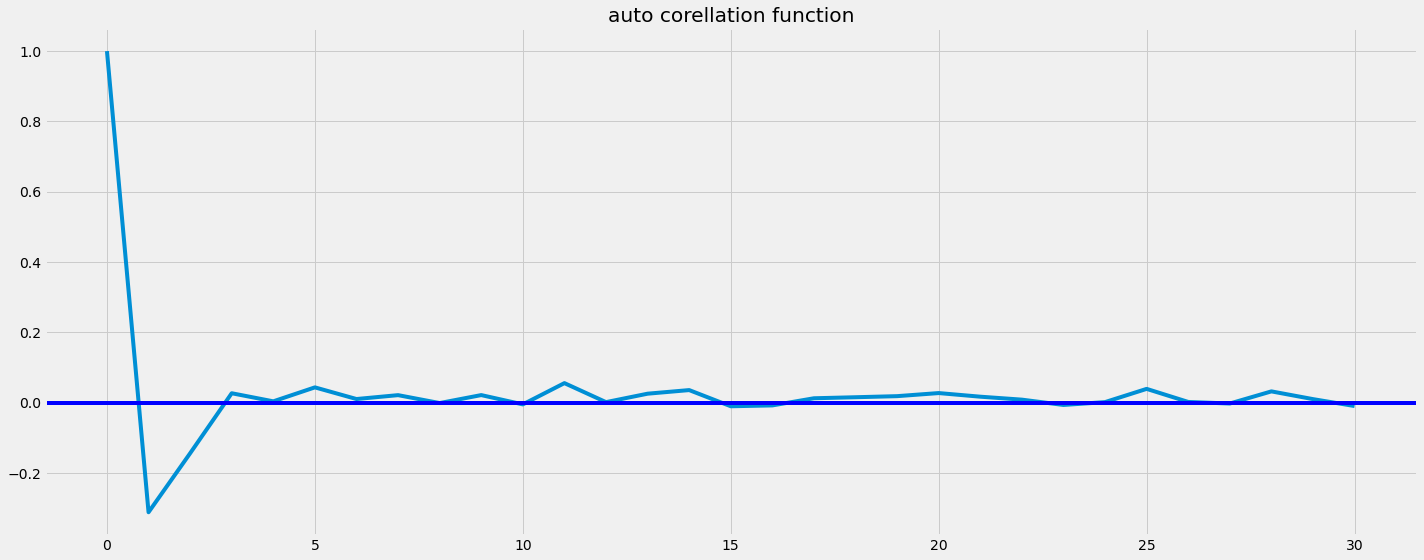

In [15]:
# we use d value here(data_log_shift)
_acf = acf(example['WL_pct'], nlags=30)
#plot ACF
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('auto corellation function')
plt.tight_layout()

### Target Distribution 

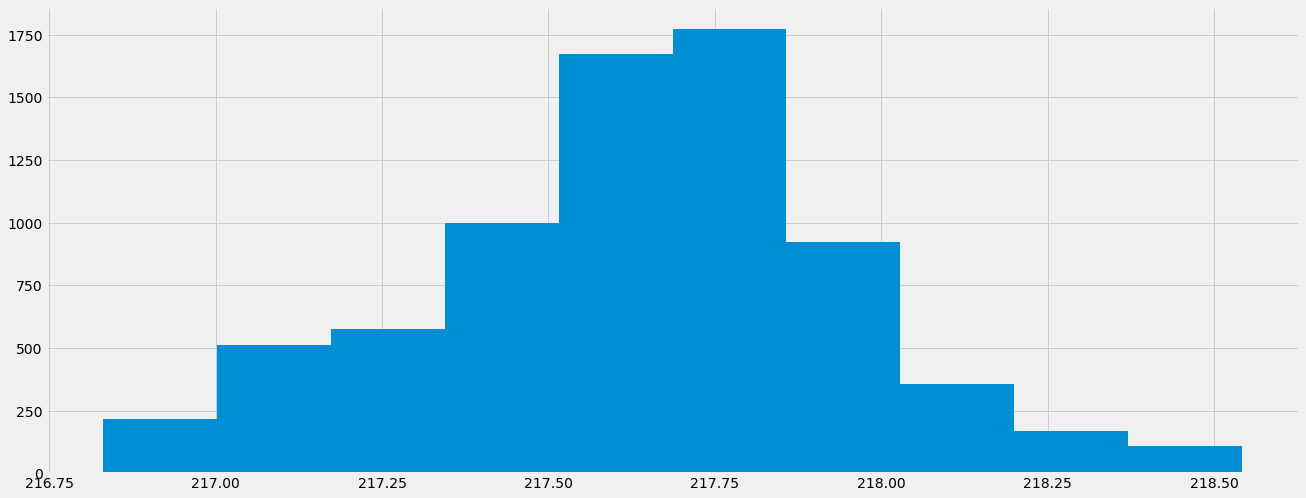

In [16]:
(example['Value']).hist()

# Anomaly Detection based on LSTM AutoEncoders

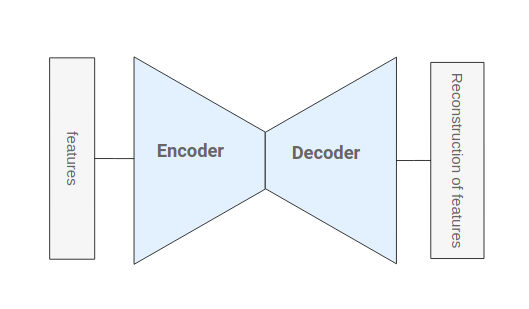

The steps we will follow to detect anomalies in Hydrometric data using an LSTM autoencoder:
* Train an LSTM autoencoder on Hydrometric data from 2000–01–01 to 2016–01–01. We assume that there were no anomalies and they were normal.

* Using the LSTM autoencoder to reconstruct the error on the test data from 2016–01–01 to 2019-12-31.

* If the reconstruction error for the test data is above the threshold, we label the data point as an anomaly.

In [17]:
# Creating Helping Features 

example['WL_mean_7']  = example['WL_pct'].rolling(7).mean()
example['WL_mean_14'] = example['WL_pct'].rolling(14).mean()
example['WL_mean_30'] = example['WL_pct'].rolling(30).mean()

example['WL_std_7']   = example['WL_pct'].rolling(7).std()
example['WL_std_30']  = example['WL_pct'].rolling(30).std()

example['WL_lag_7']   = example['WL_pct'].shift(7)
example['WL_lag_14']  = example['WL_pct'].shift(30)
example['WL_lag_30'] = example['WL_pct'].shift(180)

num_feat = ['WL_pct','WL_mean_7','WL_mean_14','WL_mean_30','WL_std_7','WL_std_30','WL_lag_7','WL_lag_30']
example.dropna(inplace = True )


In [18]:
train = example[example.Date < '2017-01-01']
test  = example[example.Date  > '2017-01-01']

In [19]:
# Hyperparameters 
train_batch_size = 256
valid_batch_size = 128
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-3
device = torch.device('cuda')
window_size = 30  
path = 'auto_encoder.pth'
verbose = False

train_dataset = hydro_dataset(train , window_size , num_feat , is_auto_encoder= True )
valid_dataset = hydro_dataset(test , window_size , num_feat , is_auto_encoder= True)

model = AutoEncoder(input_size = len(num_feat) , hidden_size = 32 , emb_size = 16) 
model = model.to(device)
val_loss, train_loss = run(
    model,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
    verbose ,
    False
)

--------- Epoch 0 ---------
 train_loss  = 0.09776763493816058
 val_loss  = 0.07470782183938557
--------- Epoch 10 ---------
 train_loss  = 0.00586580087353165
 val_loss  = 0.0099190522192253
--------- Epoch 20 ---------
 train_loss  = 0.004132119007408619
 val_loss  = 0.006563231297251251
--------- Epoch 30 ---------
 train_loss  = 0.003546401635200406
 val_loss  = 0.006228808572308885
--------- Epoch 40 ---------
 train_loss  = 0.0034447670623194426
 val_loss  = 0.004710320383310318
--------- Epoch 50 ---------
 train_loss  = 0.003324812549787263
 val_loss  = 0.005219391081482172
--------- Epoch 60 ---------
 train_loss  = 0.0033056992009126893
 val_loss  = 0.0031120234376026523
--------- Epoch 70 ---------
 train_loss  = 0.0032949735856770226
 val_loss  = 0.0030288725522243315
--------- Epoch 80 ---------
 train_loss  = 0.0032817591272760183
 val_loss  = 0.002985109652703007
--------- Epoch 90 ---------
 train_loss  = 0.003283343384585654
 val_loss  = 0.0029754373244941235


100%|██████████| 17/17 [00:00<00:00, 79.00it/s] 


<function matplotlib.pyplot.show>

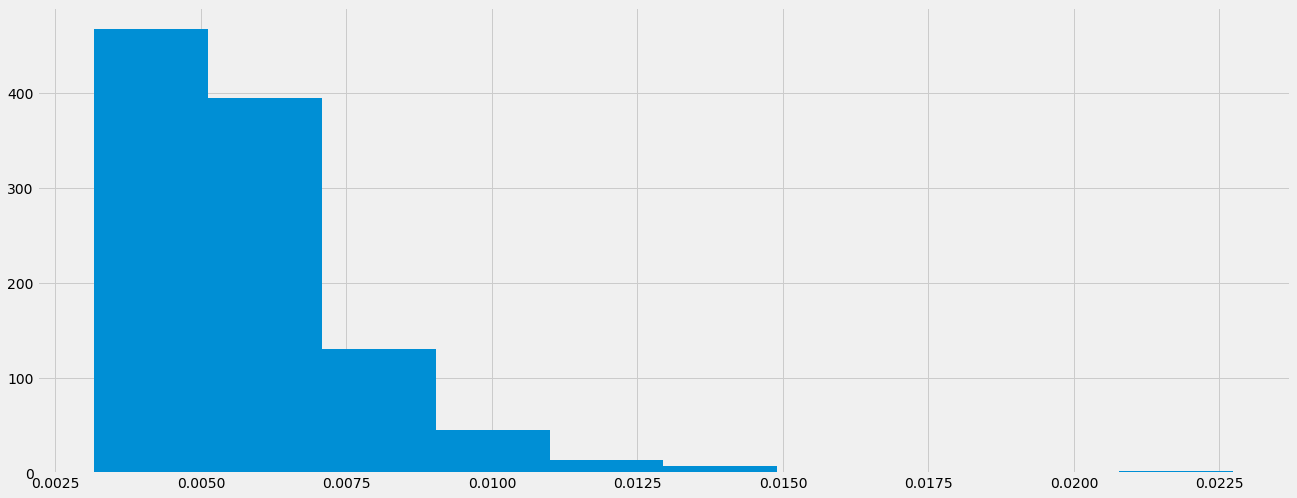

In [20]:
pred = predict_outliers(model,valid_dataset)
plt.hist(pred)
plt.show

In [21]:
thershold = 0.01
test = test.iloc[window_size:]
test['anomaly'] = pred > thershold

In [26]:
test['error'] = pred

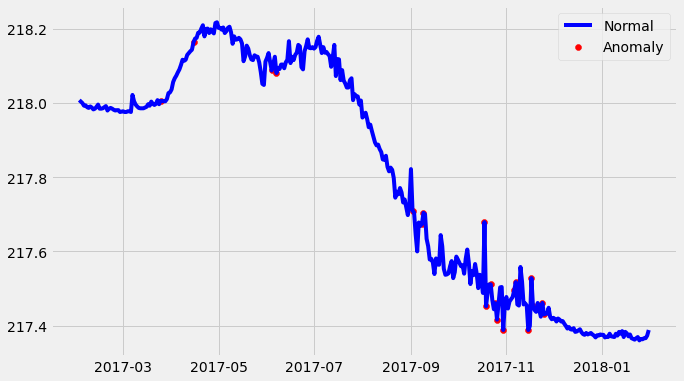

In [22]:
# visualization
fig, ax = plt.subplots(figsize=(10,6))

test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date', inplace =True)

sub_set = test.iloc[:365]
a = sub_set.loc[sub_set['anomaly'] == 1, ['Value']] #anomaly

ax.plot(sub_set.index , sub_set['Value'], color='blue', label = 'Normal')
ax.scatter(a.index , a['Value'], color='red', label = 'Anomaly')
plt.legend()
plt.show();